# Note
This notebook is to train the encoder as a classifier with the idea of validate the encoder architecture first and then use this to train the VAE.

# Parameters to experiment

In [2]:
# training on guanaco
# ATENTION: if it is going to run on guanaco:
# 1) comment the %matplotlib magic in next block and any magic (something like %code)
# 2) Change to True the trainingOnGuanaco vairbale
# 3) set epoch with an appropiate number
# 4) add comment to experiemnts
# 5) Add this file as python file 
# 6) Change launchJobOnGuanaco file to run this file but with python format
trainingOnGuanaco = False

# train without notebook
trainWithJustPython = False

# seed to generate same datasets
seed = 1

# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 8
number_experiment = str(number_experiment)

# training
epochs = 2000

In [3]:
# classes to analyze
# 42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#        95,   6,  53, 994,  64

# periodic
# only_these_labels = [16, 92, 53]

# periodic + variable
only_these_labels = [16, 92, 53, 88, 65, 6]
# 53 has 24 light curves

# only_these_labels = [16, 92]
# only_these_labels = [16, 92]
# only_these_labels = [42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#         95,   6,  53, 994,  64]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72

# band
# passband = 5
passband = [0, 1, 2, 3, 4, 5]

batch_training_size = 128

In [4]:
# training params
learning_rate = 1e-3

In [5]:
# add general comment about experiment 
# comment = "encoder as clasifier with periodic + variable (with class balancing) + 1 conv layer more"
comment = "encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + " + str(len(passband)) + " channels + seed " + str(seed)

print(comment)

encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + 6 channels + seed 1


# Import libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

# %matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
# from plasticc_plotting import plot_light_curve

import math

from torch import nn

# local imports
# %load_ext autoreload
# %autoreload 2
sys.path.append('../models')
# from classifier import EncoderClassifier, 
from classifierPrototype import EncoderClassifier

sys.path.append("./aux/")
from auxFunctions import *

# Load data

In [6]:
# define path to dataset
pathToFile = "/home/shared/astro/PLAsTiCC/" if trainingOnGuanaco else "/home/leo/Downloads/plasticc_torch-master/"

## Loading dataset with pytorch tool

In [12]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels, max_elements_per_class = 10)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
hi
hi
hi
hi
hi
hi
Found 2 csv files at given path
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_train_lightcurves.csv
Loading /home/leo/Downloads/plasticc_torch-master/plasticc_test_set_batch1.csv


In [13]:
assert torch_dataset_lazy.__len__() != 494096, "dataset should be smaller"
print("dataset test ok")

dataset test ok


# Spliting data (train/test)

In [14]:
# Spliting the data

# print(torch_dataset_lazy.__len__())

totalSize = torch_dataset_lazy.__len__()

totalSize = totalSize
# print(totalSize)

# selecting train splitting
train_size = int(0.8 * totalSize)
#print(train_size)

# getting test splitting
validation_size = math.floor((totalSize - train_size)/3)
#print(validation_size)

# getting test splitting
test_size = totalSize - train_size - validation_size
#print(test_size)

# spliting the torch dataset
trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(
    torch_dataset_lazy, 
    [train_size, validation_size, test_size],
    
    # set seed
    generator = torch.Generator().manual_seed(seed)
)

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
print("sum: ", train_size+ validation_size + test_size)

train size: 2192
validation size:  182
test size: 366
sum:  2740


## Create a dataloader

In [15]:
print("initila distribution")
initialClassesDistribution = countClasses(trainDataset, only_these_labels)

print(initialClassesDistribution)

# fig, ax = plt.subplots()
# ax.bar(x = np.arange(len(only_these_labels)), height = initialClassesDistribution)

initila distribution
[739. 196.  28. 302. 800. 127.]


In [13]:
# # Create data loader (minibatches)

# training loader
trainLoader = torch.utils.data.DataLoader(
    trainDataset, 
    batch_size = batch_training_size, 
    # to balance classes
    sampler=ImbalancedDatasetSampler(trainDataset),
)

# validation loader
validationLoader = torch.utils.data.DataLoader(
    validationDataset, 
    batch_size= batch_training_size,  
    num_workers = 4
)

# # test loader
testLoader = torch.utils.data.DataLoader(testDataset)
# trainLoader = torch.utils.data.DataLoader(torch_dataset_lazy, batch_size=256, shuffle=True, num_workers=0)

In [14]:
print("balanced distribution")
balancedClassesDistribution = countClasses(trainLoader, only_these_labels)

print(balancedClassesDistribution)
# fig, ax = plt.subplots()
# ax.bar(x = np.arange(6), height = balancedClassesDistribution)
# ax.bar(x = only_these_labels, height = temp2, width = 10)

balanced distribution
[376. 332. 382. 358. 388. 356.]


## Load the path to save model while training

In [15]:
import os

# create experiment's folder
tmpGuanaco = "/home/lbravo/thesis/work/thesis/"
tmpLocal = "/home/leo/Desktop/thesis/work/thesis/"

expPath = "experiments/" + number_experiment + "/seed" + str(seed)

folder_path = (tmpGuanaco + expPath) if trainingOnGuanaco else (tmpLocal + expPath)
# !mkdir folder_path
# os.makedirs(os.path.dirname(folder_path), exist_ok=True)

# check if folder exists
if not(os.path.isdir(folder_path)):
        
    # create folder
    try:
        os.makedirs(folder_path)
        
    except OSError as error:
        print ("Creation of the directory %s failed" % folder_path)
        print(error)
    else:
        print ("Successfully created the directory %s " % folder_path)
else:
    print("folder already exists")

# define paht to save model while training
pathToSaveModel = (tmpGuanaco + expPath + "/model") if trainingOnGuanaco else (tmpLocal + expPath + "/model")

Successfully created the directory /home/leo/Desktop/thesis/work/thesis/experiments/99/seed0 


In [16]:
# store varibales on file
text_file = open("../" + expPath + "/experimentParameters.txt" , "w")
text = "N° experiment: {7}\n General comment: {13}\n Classes: {0}\n train_size: {9}\n validation_size: {10}\n test_size: {11}\n total dataset size: {12}\n Epochs: {8}\n Latent dimension: {1}\n Hidden dimension: {2}\n Input dimension: {3}\n Passband: {4}\n Learning rate: {5}\n Batch training size: {6}\n initial train classes distribution: {14}\nbalanced train class distribution: {15}".format(only_these_labels, latentDim, hiddenDim, inputDim, passband, learning_rate, batch_training_size, number_experiment, epochs, train_size, validation_size, test_size, train_size + validation_size + test_size, comment, initialClassesDistribution, balancedClassesDistribution)
text_file.write(text)
text_file.close()
print("experiment parameters file created")

experiment parameters file created


## Defining parameters to Autoencoder

In [17]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

# passband = passband

num_classes = len(only_these_labels)


# defining model
model = EncoderClassifier(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim, num_classes = num_classes, passband = passband)

# mdel to GPU
model = model.cuda()

In [18]:
print(model)

EncoderClassifier(
  (pconv1): PartialConv(
    (input_conv): Conv1d(6, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(6, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(64, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv3): PartialConv(
    (input_conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(32, 32, kernel_size=(3,), stride=(2,), bias=False)
  )
  (hidden1): Linear(in_features=768, out_features=100, bias=True)
  (outputLayer): Linear(in_features=100, out_features=6, bias=True)
  (activationConv): ReLU()
  (activationLinear): Tanh()
)


### Training

starting the training
epoch:    0 / 3
early stopping counter:  2
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    1 / 3
New min test loss. Saving model
saving losses
saving f1 scores
epoch:    2 / 3
New min test loss. Saving model
saving losses
saving f1 scores
training has finished


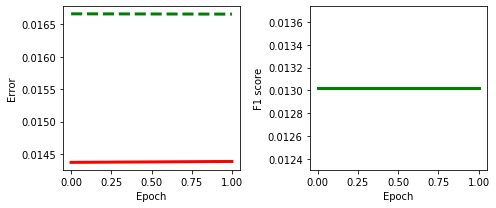

In [16]:
from sklearn.metrics import f1_score

# optimizera
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.5)

# loss function
lossFunction = nn.CrossEntropyLoss()

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# f1 scores
f1Scores = np.zeros((epochs, ))

# min global test loss 
minTestLossGlobalSoFar = float("inf")

# # # loss plot
# if it is not cluster
if (not trainingOnGuanaco) or (not trainWithJustPython):
    
    # add f1 and loss plots
    fig, ax = plt.subplots(1, 2, figsize = (7, 3), tight_layout = True)
    # # fig, ax = plt.subplots()
    
    # error
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Error")
    
    
    # f1 score
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("F1 score")
    

# early stopping
prior_test_error = 0
count_early_stop = 0
threshold_early_stop = 20


print("starting the training")


# epoch
for nepoch in range(epochs):
        
    print("epoch:    {0} / {1}".format(nepoch, epochs))
    
    
    
     
    ######## Train ###########
    epoch_train_loss = 0
    
    for data_ in trainLoader:
        
        data = data_[0]
        labels = data_[1].cuda()
#         labels = data_[1]
        
        optimizer.zero_grad()
            
        # this take the deltas (time and magnitude)
        data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()
#         data = generateDeltas(data, passband).type(torch.FloatTensor)

#         # testing tensor size 
#         assert data.shape == torch.Size([batch_training_size, len(passband), 4, 71]), "Shape should be [minibatch size, channels, 4, 71]"
#         print("test ok")
        
        # get model output
        outputs = model.forward(data)
        
#         # testing output shape size
#         assert outputs.shape == torch.Size([batch_training_size, len(only_these_labels)]), "Shape should be [minibatch, classes]"
#         print("test ok")

        # loss function
        loss = lossFunction(outputs, mapLabels(labels, only_these_labels).cuda())
        
        # backpropagation
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # add loss value (of the currrent minibatch)
        epoch_train_loss += loss.item()
        

    # get epoch loss value
    train_loss[nepoch] = epoch_train_loss / train_size
    
    
    
    
    ##### Validation ########
    
    epoch_test_loss = 0
    
    # check f1 score in each minibatch
    f1Score = 0
    
    batchCounter = 0
    
    # minibatches
    for data_ in validationLoader:
        
        data = data_[0]
        labels = data_[1].cuda()
        
        data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()
        
        outputs = model.forward(data)
        
#           # testing output shape size
#         assert outputs.shape == torch.Size([batch_training_size, len(only_these_labels)]), "Shape should be [minibatch, classes]"
#         print("test ok")

        # loss function
        loss = lossFunction(outputs, mapLabels(labels, only_these_labels).cuda())
    
        #  store minibatch loss value
        epoch_test_loss += loss.item()
        
        # f1 score
        f1Score += f1_score(mapLabels(labels, only_these_labels).cpu().numpy(), torch.argmax(outputs, 1).cpu().numpy(), average = "micro")
        
        # batch counter
        batchCounter += 1
    
    # get epoch test loss value
    test_loss[nepoch] = epoch_test_loss / validation_size
    
    # get epoch f1 score
    f1Scores[nepoch] = f1Score / batchCounter
    
    
    
    
    # plot loss values
    # if it's not cluster
    if (not trainingOnGuanaco) or (not trainWithJustPython):

        # loss values
        ax[0].plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
        ax[0].plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green")
        
        # f1 score values
        ax[1].plot(f1Scores[0: nepoch], linewidth = 3, c = "green")
        
        # plot
        fig.canvas.draw()
    
    
    #### Early stopping #####
    
    
    
    # if new test loss is greater than the older one
    count_early_stop += 1
    if epoch_test_loss > prior_test_error:
        count_early_stop += 1
        print("early stopping counter: ", count_early_stop)
    else: 
        count_early_stop = 0
    
    # update prior test error
    prior_test_error = epoch_test_loss
    
    # analyze early stopping
    if count_early_stop > threshold_early_stop:
        
        print("Early stopping in epoch: ", nepoch)
        text_file = open("../" + expPath + "/earlyStopping.txt", "w")
        metricsText = "Epoch: {0}\n ES counter: {1}\n, Reconstruction test error: {2}".format(nepoch, count_early_stop, epoch_test_loss)
        text_file.write(metricsText)
        text_file.close()
        break
        
        
        
    #### Saving best model ####
    
    # if epoch test loss is smaller than global min
    if test_loss[nepoch] < minTestLossGlobalSoFar:
        
        # update global min
        minTestLossGlobalSoFar = test_loss[nepoch]
        
        # save model
        saveBestModel(model, pathToSaveModel, number_experiment, nepoch, minTestLossGlobalSoFar, expPath)
                
   


    # save losses
    print("saving losses")
    losses = np.asarray([train_loss, test_loss]).T
    np.savetxt("../" + expPath + "/training_losses.csv", losses, delimiter=",")
    

    
    
    # save f1 scores
    print("saving f1 scores")
    np.savetxt("../" + expPath + "/f1Scores.csv", f1Scores, delimiter=",")

    
    
# final message
print("training has finished")

In [17]:
# get metrics on trainig dataset
getConfusionAndClassificationReport(trainLoader, nameLabel = "Train", passband = passband, model = model, staticLabels = only_these_labels, number_experiment = number_experiment, expPath = expPath)


# get metrics on validation dataset
getConfusionAndClassificationReport(validationLoader, nameLabel = "Validation", passband = passband, model = model, staticLabels = only_these_labels, number_experiment = number_experiment, expPath = expPath)

saving confusion matrix scores
saving clasification report


/home/leo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


saving confusion matrix scores
saving clasification report


### Stop execution if it's on cluster

In [18]:
import sys

if  trainingOnGuanaco or trainWithJustPython:

    sys.exit("Exit from code, because we are in cluster or running locally. Training has finished.")

SystemExit: Exit from code, because we are in cluster or running locally. Training has finished.

/home/leo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Analyzing training

In [7]:
seed = 1

In [8]:
!cat ../experiments/9/seed1/experimentParameters.txt

N° experiment: 9
 General comment: encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + 6 channels + seed 1
 Classes: [16, 92, 53, 88, 65, 6]
 train_size: 164360
 validation_size: 13697
 test_size: 27394
 total dataset size: 205451
 Epochs: 3000
 Latent dimension: 100
 Hidden dimension: 100
 Input dimension: 72
 Passband: [0, 1, 2, 3, 4, 5]
 Learning rate: 0.001
 Batch training size: 128
 initial train classes distribution: [40754. 40131.  1201. 40263. 40856.  1155.]
balanced train class distribution: [27577. 27557. 27360. 27368. 27189. 27309.]

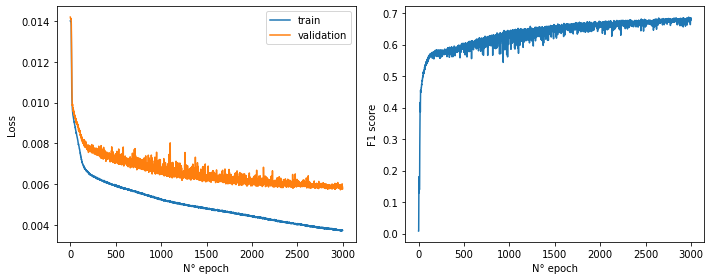

In [9]:
# load losses array
losses = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/"+ number_experiment + "/seed" + str(seed) + "/training_losses.csv")

# f1 scores
f1Scores = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/seed" + str(seed) + "/f1Scores.csv")

# plot losses
fig, ax = plt.subplots(1, 2, figsize = (10,4), tight_layout = True)

# loss
ax[0].set_xlabel("N° epoch")
ax[0].set_ylabel("Loss")
ax[0].plot(losses.iloc[:, 0], label = "train")
ax[0].plot(losses.iloc[:, 1], label = "validation")
ax[0].legend()

# f1 scores
ax[1].set_xlabel("N° epoch")
ax[1].set_ylabel("F1 score")
ax[1].plot(f1Scores)

# best model
# values copied from the txt file
# bestModelEpoch = 785
# bestModelError = 0.00434128265165168
# ax[0].scatter(bestModelEpoch, bestModelError, c = "r", linewidths = 10)
# ax[1].scatter(bestModelEpoch, f1Scores.iloc[bestModelEpoch], c = "r", linewidths = 10)

In [10]:
!cat ../experiments/9/seed1/bestScoresModelTraining.txt

Epoch: 2939
 Reconstruction test error: 0.0024663572879385066

Training


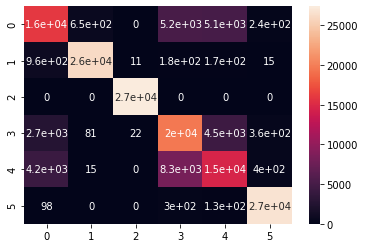

In [11]:
# confusion matrix
import pandas as pd
import seaborn as sn

# get confusion matrix
cmTrain = pd.read_csv('../experiments/' + number_experiment + "/seed" + str(seed) + '/confusionMatrixTrain.csv', header = None) 
cmValidation = pd.read_csv('../experiments/' + number_experiment + "/seed" + str(seed) + '/confusionMatrixValidation.csv', header = None) 

print("Training")
sn.heatmap(cmTrain, annot=True)

Validation


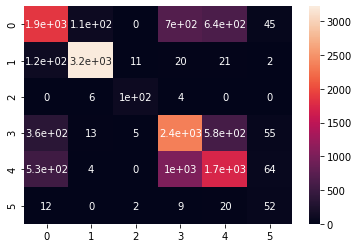

In [12]:
print("Validation")
sn.heatmap(cmValidation, annot = True)

In [13]:
# classification report
!cat ../experiments/9/seed1/clasificationReportTrain.txt

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92     27593
         1.0       0.98      0.97      0.98     27351
         2.0       1.00      1.00      1.00     27203
         3.0       0.79      0.91      0.85     27656
         4.0       0.90      0.73      0.81     27237
         5.0       0.94      0.94      0.94     27320

    accuracy                           0.92    164360
   macro avg       0.92      0.92      0.92    164360
weighted avg       0.92      0.92      0.91    164360


In [14]:
# classification report
!cat ../experiments/9/seed1/clasificationReportValidation.txt

              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      3365
         1.0       0.98      0.97      0.97      3400
         2.0       0.88      0.92      0.90       113
         3.0       0.81      0.91      0.86      3366
         4.0       0.90      0.72      0.80      3358
         5.0       0.20      0.63      0.30        95

    accuracy                           0.88     13697
   macro avg       0.78      0.84      0.79     13697
weighted avg       0.89      0.88      0.88     13697
